In [2]:
import pandas as pd 
import numpy as np
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import re
import string
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
df = pd.read_csv("/Users/aishwaryaarab/Documents/Scape-Save-DAEN690/Datasets/indeed_cleaned.csv.gz") 
cos_df = pd.read_excel("/Users/aishwaryaarab/Documents/Scape-Save-DAEN690/Datasets/careeronestop_data.xlsx")
usa_df = pd.read_excel("/Users/aishwaryaarab/Documents/Scape-Save-DAEN690/Datasets/USAJobs_data.xlsx") 

### Data Cleaning

In [4]:
#Remove duplicate postings if the job title, description and location are the same 
df.drop_duplicates(subset=['job_title', 'description_text', 'location'], inplace=True)
cos_df.drop_duplicates(subset=['job_title', 'description', 'location'], inplace=True)
usa_df.drop_duplicates(subset=['job_title', 'description', 'location'], inplace=True)

In [5]:
def clean(text):
    #remove url
    output = re.sub(r'https://\S*','', text)

    #remove numerical values 
    output = ''.join(filter(lambda x: not x.isdigit(), output))

    #convert to lowercase 
    output = output.lower()

    #remove \r, \n
    rep = r'|'.join((r'\r',r'\n'))
    output = re.sub(rep,'',output)

    #remove duplicated punctuation
    output = re.sub(r'([!()\-{};:,<>./?@#$%\^&*_~]){2,}', lambda x: x.group()[0], output)
    
    #remove extra space
    output = re.sub(r'\s+', ' ', output).strip()
    
    #remove string if string only contains punctuation
    if sum([i.isalpha() for i in output])== 0:
        output = ''
        
    return output
    
df['description_text'] = df['description_text'].apply(clean)
#convert to unicode
cos_df['description'] = (cos_df['description'].values.astype("U"))
cos_df['description']= cos_df['description'].apply(clean)
usa_df['description'] = usa_df['description'].apply(clean)

In [6]:
#Set to lowercase so capitalized titles don't get counted separately
def lowercase(out): 
    out = out.lower()
    
    return out 

df['job_title'] = df['job_title'].apply(lowercase)
#convert to unicode 
cos_df['job_title'] = (cos_df['job_title'].values.astype("U"))
cos_df['job_title'] = cos_df['job_title'].apply(lowercase)
usa_df['job_title'] = usa_df['job_title'].apply(lowercase)

In [7]:
#Create function to categorize role types 

def role_type(x):
    if 'lead' in x:
        return 'senior'
    elif 'senior' in x:
        return 'senior'
    elif 'sr' in x:
        return 'senior'
    elif 'chief' in x:
        return 'upper mgmt'
    elif 'manager' in x:
        return 'upper mgmt'
    elif 'principal' in x:
        return 'upper mgmt'
    elif 'junior' in x:
        return 'entry-level'
    elif 'jr' in x:
        return 'entry-level'
    elif 'entry-level' in x:
        return 'entry-level'
    elif 'entry level' in x:
        return 'entry-level'
    elif 'professor' in x: 
        return 'academia'
    else:
        return 'other'
    
df['role_type'] = df['job_title'].apply(role_type)
cos_df['role_type'] = cos_df['job_title'].apply(role_type)
usa_df['role_type'] = usa_df['job_title'].apply(role_type)

#Can be used for visualizations 
df_in = df.groupby('role_type').count().reset_index()[['role_type', 'job_title']]
df_cos = cos_df.groupby('role_type').count().reset_index()[['role_type', 'job_title']]
df_usa = usa_df.groupby('role_type').count().reset_index()[['role_type', 'job_title']]

### BERTopic Model

In [8]:
from bertopic import BERTopic 

In [9]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic 
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

seed_topic_list = [["security", "cybersecurity", "information security", "technical", "forensic support"
                    "architect", "information", "penetration", "knowledge", "solution", "nist", "soc", "dod", "network", 
                     "risk management", "risk", "data", "cyber", "system", "privacy", "tester", "incident response", "vulnerability", "skill"
                     "network", "data", "policy", "procedure"]]

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings #10 or 30 
hdbscan_model = HDBSCAN(min_cluster_size=30, min_samples=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
# ngram_range set to 2 so the topics extracted can also be 'two-words' instead of one 
vectorizer_model = CountVectorizer(ngram_range=(1,3), stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - Fine-tune topic representations with 
# reduces redundacy and improve diversity of keywords using MMR 
representation_model = MaximalMarginalRelevance(0.5)

#CareerOneStop model 
topic_model = BERTopic(
  embedding_model=embedding_model, # Step 1: Embedding        
  umap_model=umap_model, # Step 2: Dimensionality reduction                   
  hdbscan_model=hdbscan_model, # Step 3: Clustering              
  vectorizer_model=vectorizer_model, # Step 4: Tokenizer         
  ctfidf_model=ctfidf_model, # Step 5: Weighting scheme                
  representation_model=representation_model, nr_topics=25, seed_topic_list=seed_topic_list) # Step 6: Fine-tune topic representation 

#Indeed model 
topic_model_in = BERTopic(
  embedding_model=embedding_model,          
  umap_model=umap_model,                    
  hdbscan_model=hdbscan_model,              
  vectorizer_model=vectorizer_model,       
  ctfidf_model=ctfidf_model,                
  representation_model=representation_model, 
  nr_topics=25, seed_topic_list=seed_topic_list) 

#USAjobs model 
topic_model_usa = BERTopic(
  embedding_model=embedding_model,          
  umap_model=umap_model,                    
  hdbscan_model=hdbscan_model,              
  vectorizer_model=vectorizer_model,       
  ctfidf_model=ctfidf_model,                
  representation_model=representation_model, 
  nr_topics=25, seed_topic_list=seed_topic_list)

In [10]:
#Indeed model
topic_in, prob_in = topic_model_in.fit_transform(df['description_text'].values.astype('U'))

In [11]:
#CareerOneStop model
topic, prob = topic_model.fit_transform(cos_df['description'].values.astype('U'))

In [12]:
#USAjobs model 
topic_usa, prob_usa = topic_model_usa.fit_transform(usa_df['description'].values.astype('U'))

In [13]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,921,-1_experience_information_cybersecurity_technical
1,0,6039,0_information_experience_technical_cybersecurity
2,1,372,1_ctg_information security_cerner millennium_umb
3,2,176,2_xerox_relativity_forensic_incident response
4,3,161,3_smx_cloud security architect_security archit...
5,4,112,4_rubrik_cloud_equity_employment
6,5,106,5_compensation range_pwc_oracle_pricewaterhous...
7,6,103,6_travelers_automation_preferred experience_role
8,7,100,7_guidehouse_required_northrop grumman_navair
9,8,74,8_icims_azure aws gcp_aws_information


In [14]:
topic_model_usa.get_topic_info()

,Topic,Count,Name
0,-1,14,-1_fema_dhs_emergency management_join
1,0,49,0_information_employment_federal_certification
2,1,203,1_systems_requirements_federal_dod


In [15]:
topic_model_in.get_topic_info()

,Topic,Count,Name
0,-1,3908,-1_information_experience_cybersecurity_technical
1,0,4421,0_experience_cybersecurity_risk_support
2,1,433,1_experience_development_application security_...
3,2,206,2_palo alto networks_cox_benefits_privacy
4,3,195,3_mitre_experience_servicenow_employees
5,4,173,4_verizon_experience_requirements_pscu
6,5,146,5_software_intelerad_guidehouse_optiv
7,6,100,6_security_technical_vulnerability management_...
8,7,92,7_northrop_security_northrop grumman employees...
9,8,79,8_change healthcare_employment_information_inc...


In [16]:
freq = topic_model.get_topic_info()

In [ ]:
topic_model_in.visualize_barchart()

In [ ]:
topic_model.visualize_barchart()

In [19]:
topic_model_usa.visualize_barchart()

In [20]:
topic_model.get_topic(freq.iloc[15]["Topic"])

[('american heart association', 0.020603765318644798),
 ('infrastructure', 0.011963448841818282),
 ('devsecops', 0.010712530139670395),
 ('support', 0.01065750422345943),
 ('configuration management', 0.010592342153852937),
 ('national center', 0.009856077175038254),
 ('prevention', 0.00927669988574226),
 ('data', 0.007997327293733836),
 ('monitoring', 0.007975661518097912),
 ('technical', 0.007880389615896786)]

In [21]:
topic_model.visualize_heatmap()

In [22]:
topic_model_in.visualize_heatmap()

In [23]:
topic_model_usa.visualize_heatmap()

In [24]:
#merge topics with similarities > 0.85 

#CareerOneStop model 
topics_to_merge_cos = [4,0]
topic_model.merge_topics(cos_df['description'], topics_to_merge_cos)

#USAjobs model 
topics_to_merge_usa = [3,0]
topic_model_usa.merge_topics(usa_df['description'], topics_to_merge_usa)

In [25]:
#CareerOneStop model intertopic distance map 
topic_model.visualize_topics()

In [26]:
#Indeed model intertopic distance map 
topic_model_in.visualize_topics()

#Unable to generate an intertopic distance map for USAjobs model as an error is generated due to having too few topics 

In [27]:
#save models for future references 
# topic_model.save("cos_model")
# topic_model_in.save("in_model")
# topic_model_usa.save("usa_model")

In [28]:
#load model 
topic_model_usa = BERTopic.load("cos_model")
topic_model_in = BERTopic.load("in_model")
topic_model = BERTopic.load("usa_model")

### Topic Mapping 

In [29]:
#Add the topic for each record in the dataframe - CareerOneStop, Indeed & USA Jobs Data
cos_df['topic'] = topic
df['topic_in'] = topic_in
usa_df['topic_usa'] = topic_usa

In [30]:
#Get the top 15 job titles from CareerOneStop
cos_titles = pd.read_excel("/Users/aishwaryaarab/Downloads/careeronestop_job_titles_freq.xlsx")
cos_titles = cos_titles[0:15]

#choose the top 10 job titles from the dataset(indeed)
cos_title_list = cos_titles.iloc[:, 0].tolist()
cos_title_list

['security architect',
 'security analyst',
 'cybersecurity engineer',
 'cybersecurity architect',
 'cybersecurity analyst',
 'information security analyst',
 'information security engineer',
 'cybersecurity specialist',
 'security engineer',
 'cybersecurity technologist',
 'information security architect',
 'information security operation analyst',
 'lead solutions architect',
 'penetration tester',
 'cybersecurity manager']

In [31]:
#Create a data frame containing job_title and the corresponding topic for CareerOneStop
cos_topic_df = cos_df[['job_title', 'topic']]
cos_topic_df

,job_title,topic
0,chief information security officer (ciso),3
1,deputy chief information security officer (cis...,-1
2,chief information security office ciso busine...,0
3,chief information security officer,8
4,"vice president, chief privacy & security offic...",0
...,...,...
11794,armed officer - campus security officer - imme...,0
11797,security officer responder - 3rd shift - $17 p...,0
11798,geotechnical engineer/geologist (experienced a...,0
11800,information assurance engineer,0


In [32]:
#Add new column for the cleaned job titles
from fuzzywuzzy import fuzz, process
def find_match_2(job_title):
    best_match, score = process.extractOne(job_title, cos_title_list)
    if score >= 90.5:  # set a threshold for similarity score
        return best_match
    else:
        return None
cos_topic_df['new_job_title'] = cos_topic_df['job_title'].apply(find_match_2)

cos_topic_df

,job_title,topic,new_job_title
0,chief information security officer (ciso),3,None
1,deputy chief information security officer (cis...,-1,None
2,chief information security office ciso busine...,0,None
3,chief information security officer,8,None
4,"vice president, chief privacy & security offic...",0,None
...,...,...,...
11794,armed officer - campus security officer - imme...,0,None
11797,security officer responder - 3rd shift - $17 p...,0,None
11798,geotechnical engineer/geologist (experienced a...,0,None
11800,information assurance engineer,0,None


In [33]:
#Get counts of all job titles
cos_topic_df['new_job_title'].value_counts()

information security engineer             372
information security analyst              335
cybersecurity engineer                    289
cybersecurity architect                   283
security architect                        278
cybersecurity analyst                     240
security analyst                          179
information security architect            128
information security operation analyst     93
cybersecurity manager                      48
penetration tester                         41
security engineer                          28
cybersecurity specialist                   24
lead solutions architect                    6
Name: new_job_title, dtype: int64

In [34]:
#Group all keywords with a certain topic - CareerOneStop
topic_0 = cos_topic_df[cos_topic_df['topic'] == 0].groupby('new_job_title')['new_job_title'].count().sort_values(ascending=True).to_frame()
topic_2 = cos_topic_df[cos_topic_df['topic'] == 2].groupby('new_job_title')['new_job_title'].count().sort_values(ascending=True).to_frame()
topic_3 = cos_topic_df[cos_topic_df['topic'] == 3].groupby('new_job_title')['new_job_title'].count().sort_values(ascending=True).to_frame()
topic_6 = cos_topic_df[cos_topic_df['topic'] == 6].groupby('new_job_title')['new_job_title'].count().sort_values(ascending=True).to_frame()
topic_8 = cos_topic_df[cos_topic_df['topic'] == 8].groupby('new_job_title')['new_job_title'].count().sort_values(ascending=True).to_frame()
topic_10 = cos_topic_df[cos_topic_df['topic'] == 10].groupby('new_job_title')['new_job_title'].count().sort_values(ascending=True).to_frame()

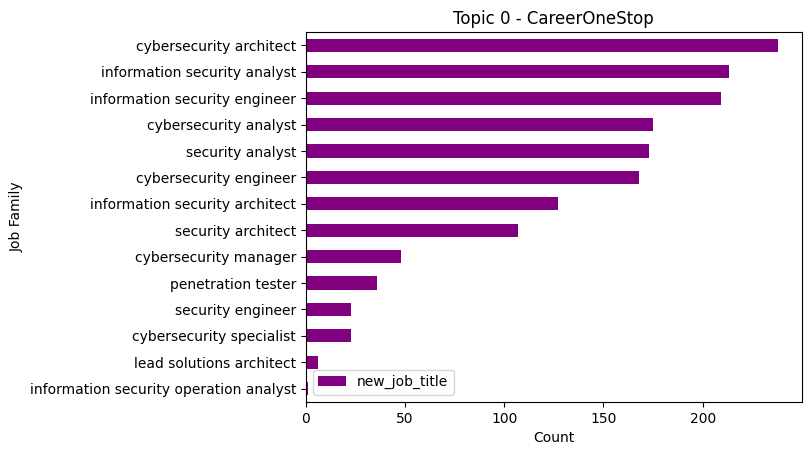

In [35]:
#Visualization for Topic0 - CareerOneStop
ax = topic_0.plot.barh(color='purple')

# set the title and axis labels
ax.set_title('Topic 0 - CareerOneStop')
ax.set_xlabel('Count')
ax.set_ylabel('Job Family')

# for i, v in enumerate(topic_0['keyword']):
#     ax.text(v + 1, i, str(v), ha='left', va='center')

# show the plot
plt.show()

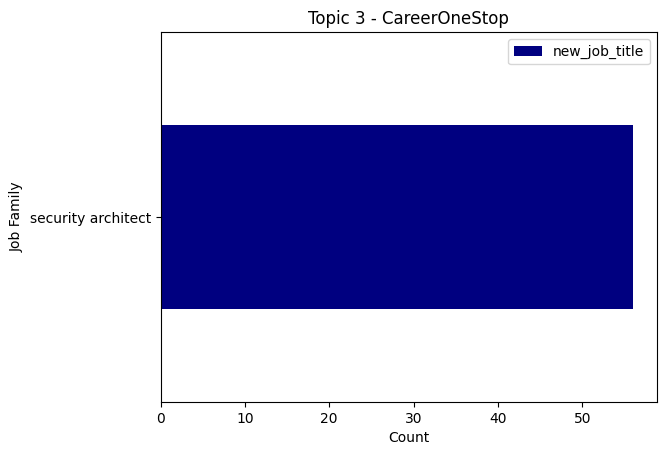

In [36]:
#Visualization for Topic3 - CareerOneStop
ax = topic_3.plot.barh(color='navy')

# set the title and axis labels
ax.set_title('Topic 3 - CareerOneStop')
ax.set_xlabel('Count')
ax.set_ylabel('Job Family')

# for i, v in enumerate(topic_0['keyword']):
#     ax.text(v + 1, i, str(v), ha='left', va='center')

# show the plot
plt.show()

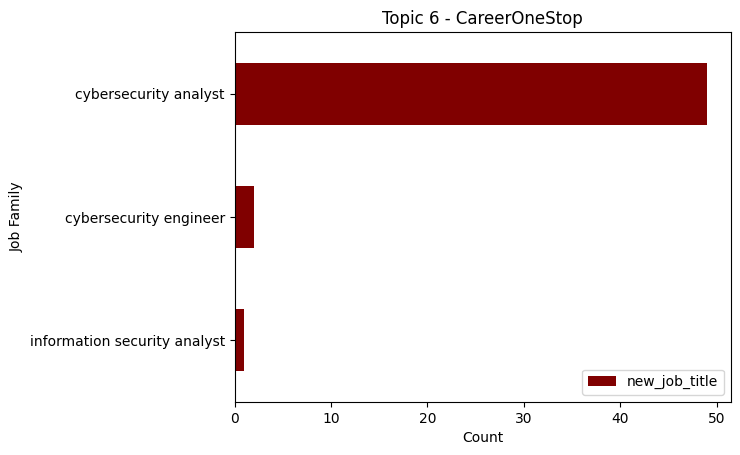

In [37]:
#Visualization for Topic6 - CareerOneStop
ax = topic_6.plot.barh(color='maroon')

# set the title and axis labels
ax.set_title('Topic 6 - CareerOneStop')
ax.set_xlabel('Count')
ax.set_ylabel('Job Family')

# for i, v in enumerate(topic_0['keyword']):
#     ax.text(v + 1, i, str(v), ha='left', va='center')

# show the plot
plt.show()

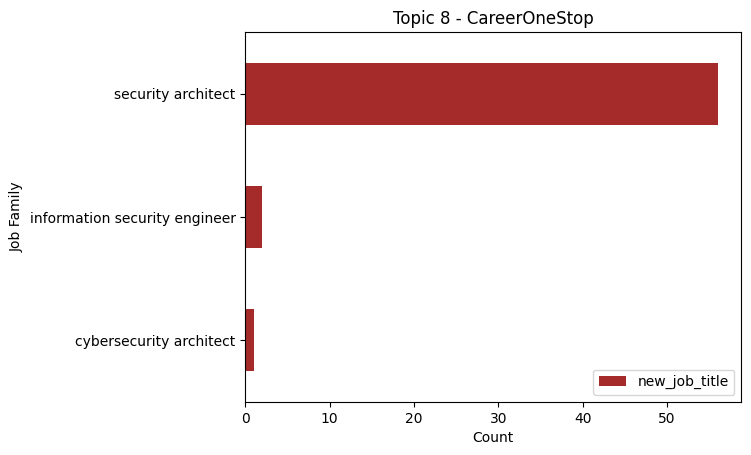

In [38]:
#Visualization for Topic8 - CareerOneStop
ax = topic_8.plot.barh(color='brown')

# set the title and axis labels
ax.set_title('Topic 8 - CareerOneStop')
ax.set_xlabel('Count')
ax.set_ylabel('Job Family')

# for i, v in enumerate(topic_0['keyword']):
#     ax.text(v + 1, i, str(v), ha='left', va='center')

# show the plot
plt.show()

Indeed Dataset Topic Mapping

In [40]:
#Get top 15 job titles from Indeed dataset
indeed_titles = pd.read_excel("/Users/aishwaryaarab/Downloads/indeed_job_titles_freq.xlsx")
indeed_titles = indeed_titles[0:15]

#choose the top 10 job titles from the dataset(indeed)
indeed_title_list = indeed_titles.iloc[:, 0].tolist()
indeed_title_list

['security engineer',
 'cybersecurity engineer',
 'security architect',
 'cybersecurity analyst',
 'security analyst',
 'information security analyst',
 'cybersecurity specialist',
 'information system security officer',
 'application security engineer',
 'penetration tester',
 'information security engineer',
 'cybersecurity architect',
 'cloud security engineer',
 'information security manager',
 'network security engineer']

In [41]:
#Create a data frame containing job_title and the corresponding topic for Indeed
indeed_topic_df = df[['job_title', 'topic_in']]

In [42]:
#Add a new column for the cleaned job titles
def find_match_2(job_title):
    best_match, score = process.extractOne(job_title, indeed_title_list)
    if score >= 90.5:  # set a threshold for similarity score
        return best_match
    else:
        return None
indeed_topic_df['new_job_title'] = indeed_topic_df['job_title'].apply(find_match_2)

indeed_topic_df

,job_title,topic_in,new_job_title
0,senior cyber security account executive (remot...,-1,None
1,cyber defense analyst iii,23,None
2,senior cybersecurity incident response analyst,8,None
3,managing principal - cybersecurity,-1,None
4,cybersecurity systems analyst,0,cybersecurity analyst
...,...,...,...
10731,director of it management (ciso),-1,None
10733,"program manager, compliance, google cloud ciso",0,None
10734,head of program management - office of the ciso,-1,None
10735,"lead technical program manager, compliance ena...",0,None


In [43]:
#Get counts of all the job titles
indeed_topic_df['new_job_title'].value_counts()

cybersecurity engineer                 487
security engineer                      395
cybersecurity analyst                  338
information security analyst           322
security architect                     268
information security engineer          265
application security engineer          195
security analyst                       169
information system security officer    164
information security manager           138
cloud security engineer                137
cybersecurity specialist               112
cybersecurity architect                102
network security engineer              101
penetration tester                      83
Name: new_job_title, dtype: int64

In [44]:
#Group all keywords with a certain topic - Indeed frame()
topic_in_1 = indeed_topic_df[indeed_topic_df['topic_in'] == 1].groupby('new_job_title')['new_job_title'].count().sort_values(ascending=True).to_frame()
topic_in_4 = indeed_topic_df[indeed_topic_df['topic_in'] == 4].groupby('new_job_title')['new_job_title'].count().sort_values(ascending=True).to_frame()
topic_in_7 = indeed_topic_df[indeed_topic_df['topic_in'] == 7].groupby('new_job_title')['new_job_title'].count().sort_values(ascending=True).to_frame()
topic_in_14 = indeed_topic_df[indeed_topic_df['topic_in'] == 14].groupby('new_job_title')['new_job_title'].count().sort_values(ascending=True).to_frame()
topic_in_17 = indeed_topic_df[indeed_topic_df['topic_in'] == 17].groupby('new_job_title')['new_job_title'].count().sort_values(ascending=True).to_frame()

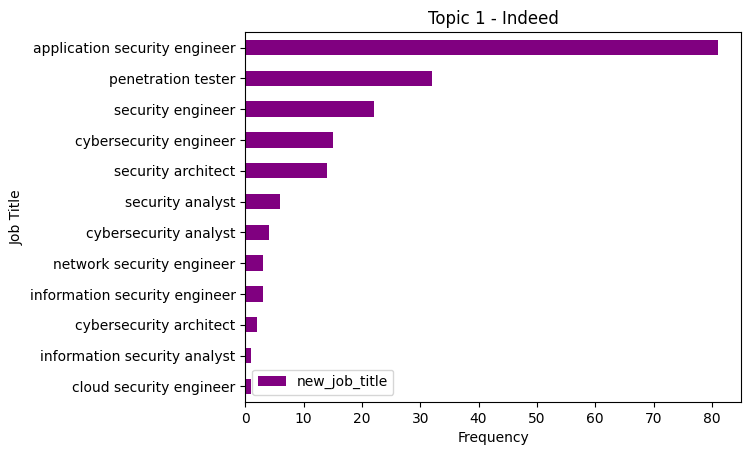

In [45]:
#Topic 1 - Indeed
ax = topic_in_1.plot.barh(color='purple')

# set the title and axis labels
ax.set_title('Topic 1 - Indeed')
ax.set_xlabel('Frequency')
ax.set_ylabel('Job Title')

# show the plot
plt.show()

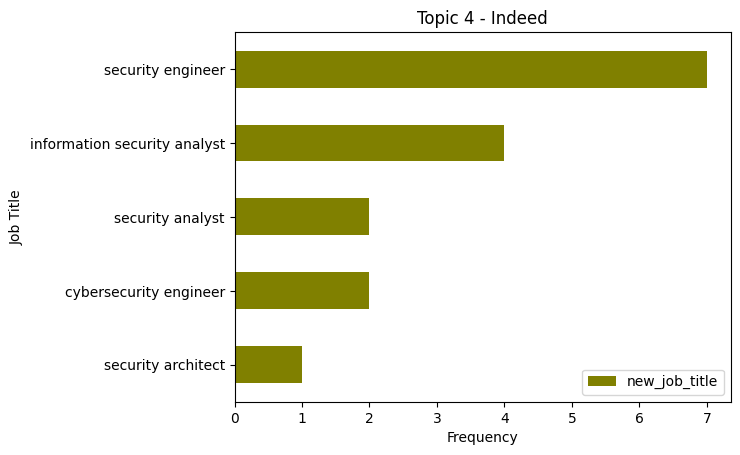

In [46]:
#Topic 4 - Indeed
ax = topic_in_4.plot.barh(color='olive')

# set the title and axis labels
ax.set_title('Topic 4 - Indeed')
ax.set_xlabel('Frequency')
ax.set_ylabel('Job Title')

# show the plot
plt.show()

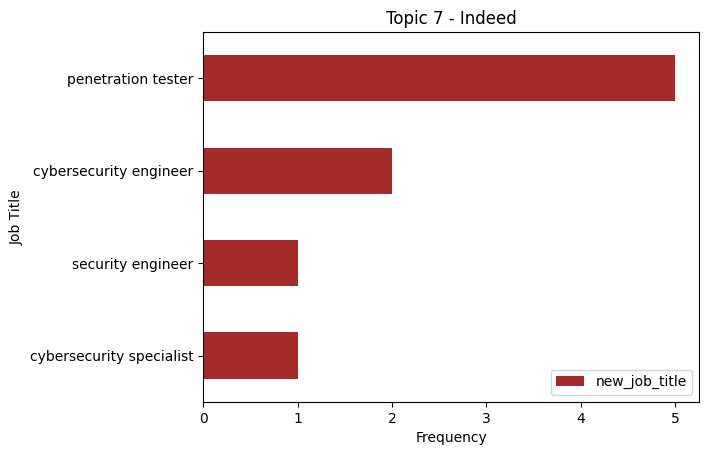

In [47]:
#Topic 7 - Indeed
ax = topic_in_7.plot.barh(color='brown')

# set the title and axis labels
ax.set_title('Topic 7 - Indeed')
ax.set_xlabel('Frequency')
ax.set_ylabel('Job Title')

# show the plot
plt.show()

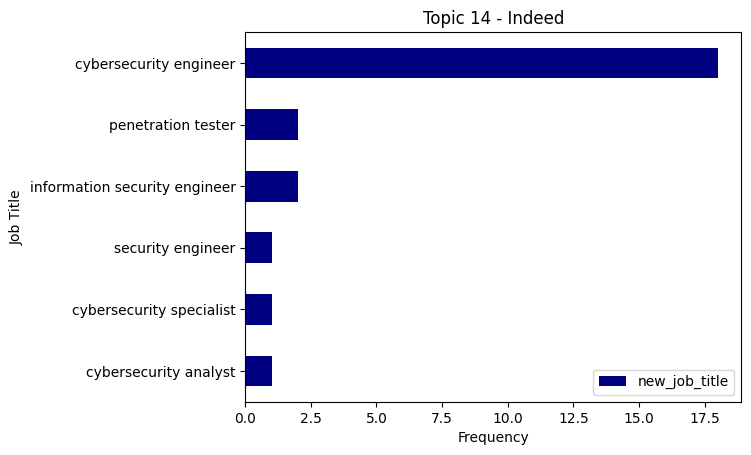

In [48]:
#Topic 14 - Indeed
ax = topic_in_14.plot.barh(color='navy')

# set the title and axis labels
ax.set_title('Topic 14 - Indeed')
ax.set_xlabel('Frequency')
ax.set_ylabel('Job Title')

# show the plot
plt.show()

USA Jobs Topic Mapping

In [50]:
#Create a dataframe of titles & topics for USA Jobs
usajobs_titles = pd.read_excel("/Users/aishwaryaarab/Downloads/USAJobs_job_titles_freq.xlsx")
usajobs_titles=usajobs_titles[0:5]

#choose the top 5 job titles from the dataset(USA Jobs)
usajobs_titles_list = usajobs_titles.iloc[:, 0].tolist()
usajobs_titles_list

['cybersecurity specialist',
 'information technology specialist',
 'specialist infosec',
 'intelligence operation specialist',
 'specialist custspt']

In [51]:
#Create a data frame containing job_title and the corresponding topic for USA Jobs
usa_topic_df = usa_df[['job_title', 'topic_usa']]
usa_topic_df

,job_title,topic_usa
0,it cybersecurity - direct hire,1
1,director cybersecurity group and ic ciso,1
2,director cybersecurity group and ic ciso,1
3,it specialist (infosec),-1
4,it specialist (sysanalysis),1
...,...,...
268,information technology specialist (sysanalysis),1
269,intelligence operations specialist,1
270,supervisory it specialist,-1
271,information technology specialist,1


In [52]:
#Add a new column with the cleaned job titles
titles_usa = []
for index, row in usa_topic_df.iterrows():
    if 'cybersecurity specialist' in row['job_title']:
        titles_usa.append('cybersecurity specialist')
    elif 'information technology specialist' in row['job_title']:
        titles_usa.append('information technology specialist')
    elif 'specialist infosec' in row['job_title']:
        titles_usa.append('specialist infosec')
    elif 'intelligence operation specialist' in row['job_title']:
        titles_usa.append('intelligence operation specialist')
    elif 'custspt' in row['job_title']:
        titles_usa.append('specialist custspt')
    else:
        titles_usa.append('other')
usa_topic_df.insert(loc=1, column = 'titles', value=titles_usa)
usa_topic_df.reset_index(inplace=True)

In [53]:
#Value counts of the titles
usa_topic_df['titles'].value_counts()

other                                169
information technology specialist     51
cybersecurity specialist              33
specialist custspt                    12
specialist infosec                     1
Name: titles, dtype: int64

In [54]:
#Drop all records with the value 'other'
usa_topic_df = usa_topic_df[usa_topic_df['titles'] != 'other']
usa_topic_df

,index,job_title,titles,topic_usa
7,7,information technology specialist(infosec),information technology specialist,0
11,11,it cybersecurity specialist (infosec),cybersecurity specialist,1
17,17,supervisory it cybersecurity specialist(infosec),cybersecurity specialist,0
20,20,it specialist (custspt),specialist custspt,1
23,23,it specialist (custspt),specialist custspt,1
...,...,...,...,...
249,256,it specialist (custspt),specialist custspt,-1
250,257,information technology specialist (network ser...,information technology specialist,0
255,262,information technology specialist (sysadm),information technology specialist,-1
261,268,information technology specialist (sysanalysis),information technology specialist,1


In [55]:
#Group all keywords with a certain topic - USA Jobs
#USA Jobs only has 2 topics; topic 0 & 1
topic_usa_0 = usa_topic_df[usa_topic_df['topic_usa'] == 0].groupby('titles')['titles'].count().sort_values(ascending=True).to_frame()
topic_usa_1 = usa_topic_df[usa_topic_df['topic_usa'] == 1].groupby('titles')['titles'].count().sort_values(ascending=True).to_frame()

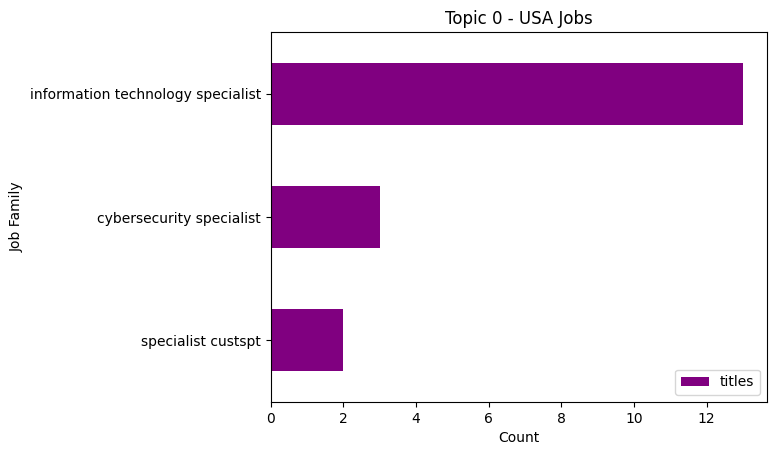

In [56]:
#Visualization for Topic0 - USA Jobs
ax = topic_usa_0.plot.barh(color='purple')

# set the title and axis labels
ax.set_title('Topic 0 - USA Jobs')
ax.set_xlabel('Count')
ax.set_ylabel('Job Family')

# show the plot
plt.show()

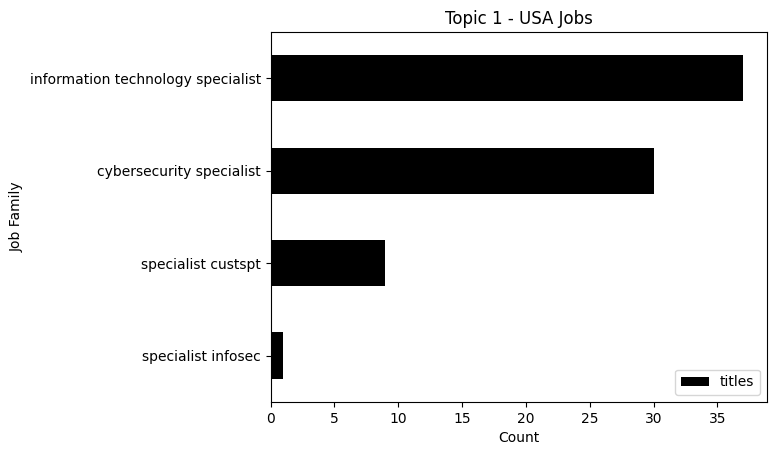

In [57]:
#Visualization for Topic 1 - USA Jobs
ax = topic_usa_1.plot.barh(color='black')

# set the title and axis labels
ax.set_title('Topic 1 - USA Jobs')
ax.set_xlabel('Count')
ax.set_ylabel('Job Family')

# show the plot
plt.show()